In [1]:
import torch
flag = torch.cuda.is_available()
print(flag)

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

True
cuda:0
GeForce MX150


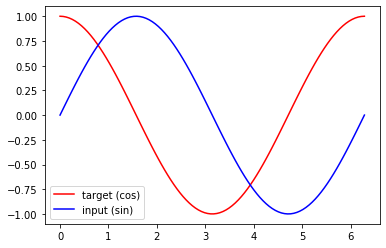

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)  # float32 for converting torch FloatTensor
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(  # 这回一个普通的 RNN 就能胜任
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入

        outs = []    # 保存所有时间点的预测值
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

rnn = RNN()
rnn.cuda()

if torch.cuda.is_available():
    print("Using GPU")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rnn.to(device)

Using GPU


RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

# 訓練

In [4]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.MSELoss()

h_state = None   # 要使用初始 hidden state, 可以设成 None

plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

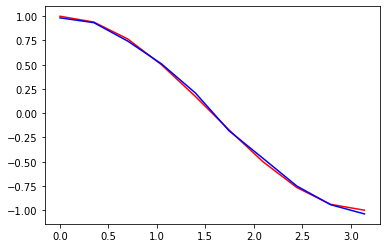

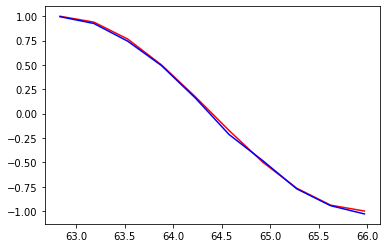

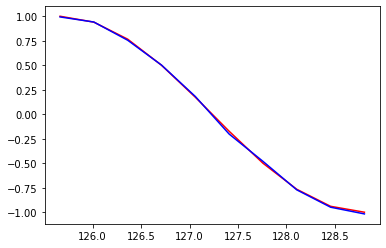

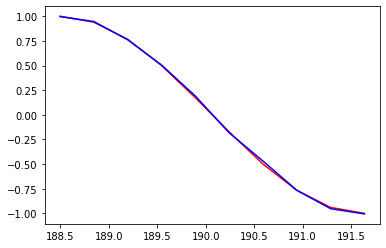

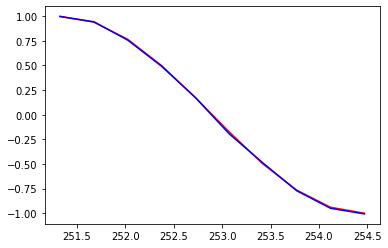

In [9]:
for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time steps
    # sin 预测 cos
    steps = np.linspace(start, end, 10, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]).cuda()    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis]).cuda()

    prediction, h_state = rnn(x, h_state)   # rnn 对于每个 step 的 prediction, 还有最后一个 step 的 h_state
    # !!  下一步十分重要 !!
    h_state = h_state.data  # 要把 h_state 重新包装一下才能放入下一个 iteration, 不然会报错

    loss = loss_func(prediction, y)     # cross entropy loss
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward()                     # backpropagation, compute gradients
    optimizer.step()                    # apply gradients

    if step % 20 ==0:
        # plotting
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw(); plt.pause(0.05)
        
last_state = h_state
plt.ioff()
plt.show()

# 保存

In [7]:
import os
if not os.path.exists('rnn_regression'): os.makedirs('rnn_regression')
torch.save(rnn, 'rnn_regression/net.pkl')  # 保存整个网络
torch.save(rnn.state_dict(), 'rnn_regression/net_params.pkl')   # 只保存网络中的参数 (速度快, 占内存少)

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 提取網絡

In [11]:
def restore_net():
    rnn = torch.load('rnn_regression/net.pkl')
    
    prediction, h_state = rnn(x, last_state)   # rnn 对于每个 step 的 prediction, 还有最后一个 step 的 h_state
    print(prediction, h_state)
    
restore_net()

tensor([[[0.8421],
         [0.6699],
         [0.4695],
         [0.5005],
         [0.5705],
         [0.6273],
         [0.7618],
         [0.8519],
         [0.9901],
         [1.0679]]], device='cuda:0', grad_fn=<StackBackward>) tensor([[[ 0.6303,  0.4163,  0.7437, -0.5750, -0.3156, -0.2915,  0.0164,
          -0.1755, -0.4192, -0.5898, -0.6577, -0.1294,  0.0432,  0.1870,
          -0.4512,  0.8725, -0.1242, -0.0094,  0.4530, -0.7923, -0.7696,
          -0.6265,  0.5476, -0.0104, -0.1429,  0.4618,  0.9458,  0.3071,
          -0.3421, -0.1949, -0.1559, -0.2480]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward>)


D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
